In [3]:
import numpy as np
import os
import pandas as pd
import itertools
from PIL import Image
import seaborn as sns
import fitsio
import skimage.io
import galsim

from astrometry.util.fits import fits_table, merge_tables


# to make this notebook's output stable across runs
np.random.seed(7)

# To plot pretty figures
#%matplotlib inline
%matplotlib notebook

import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

%load_ext autoreload
%autoreload 2

In [32]:
from obiwan.qa.visual import readImage,sliceImage,plotImage, flux2mag

# testcase_DR_z

In [19]:
OUT_DIR= os.path.join(os.environ['HOME'],
                       'myrepo/obiwan/tests/end_to_end',
                       'out_testcase_DR5_z/elg/174/1741p242/rs0/')
IN_DIR= os.path.join(os.environ['HOME'],
                       'myrepo/obiwan/tests/end_to_end',
                       'testcase_DR5_z/')

simcat= fits_table(os.path.join(OUT_DIR,'obiwan/simcat-elg-1741p242.fits'))
obitractor= fits_table(os.path.join(OUT_DIR,'tractor/tractor-1741p242.fits'))

blobs= fitsio.FITS(os.path.join(OUT_DIR,'metrics/blobs-1741p242.fits.gz'))[0].read()

img_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-1741p242-image.jpg'),
                   jpeg=True)
model_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-1741p242-model.jpg'),
                     jpeg=True)
resid_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-1741p242-resid.jpg'),
                     jpeg=True)
                            

In [20]:
len(simcat),len(obitractor),blobs.shape

(4, 3, (200, 200))

<IPython.core.display.Javascript object>


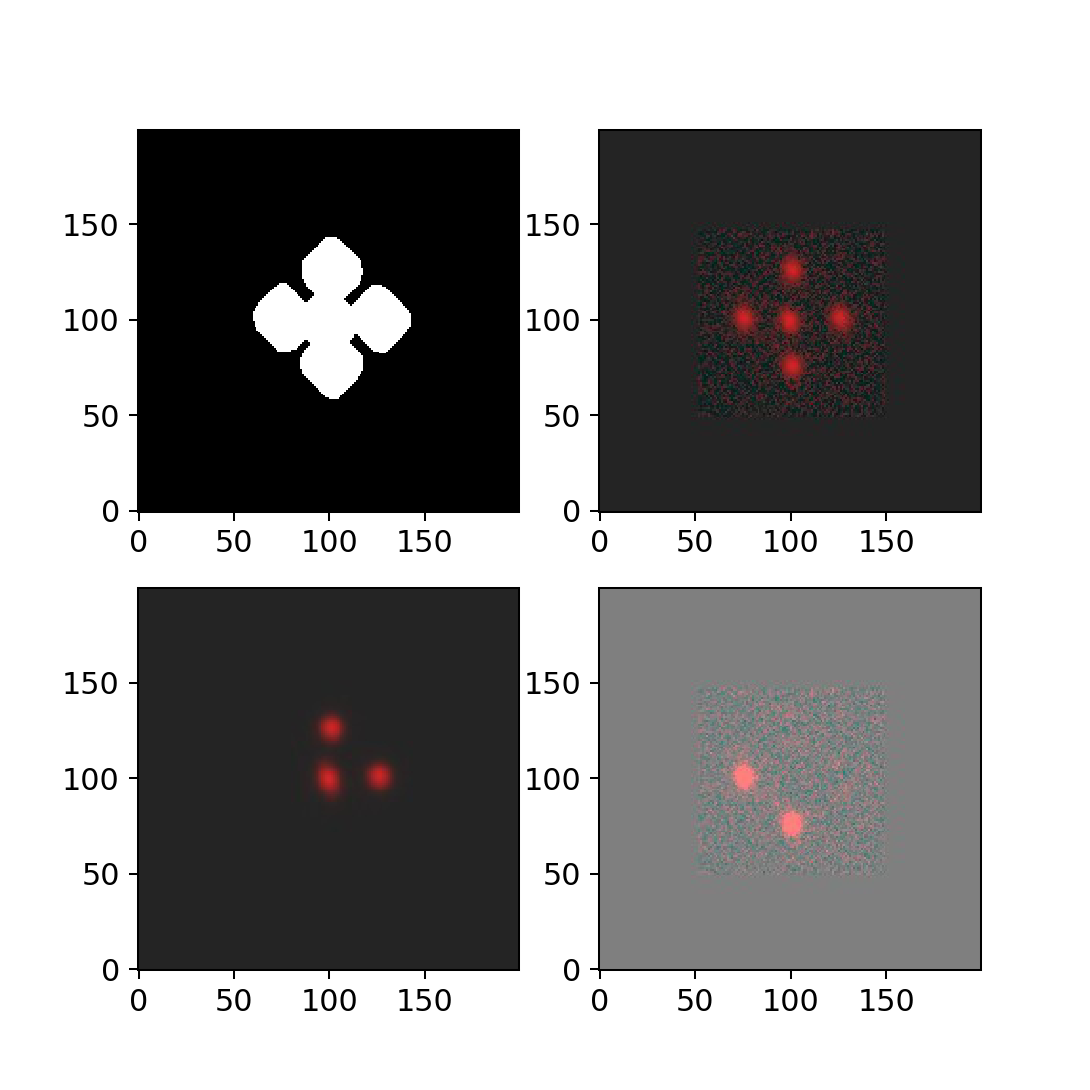

In [22]:
fig,ax=plt.subplots(2,2,figsize=(6,6))
plotImage().imshow(blobs,ax[0,0],qs=None)
plotImage().imshow(img_jpg,ax[0,1],qs=None)
plotImage().imshow(model_jpg,ax[1,0],qs=None)
plotImage().imshow(resid_jpg,ax[1,1],qs=None)

# testcase_DR_z_allblobs

In [23]:
OUT_DIR= os.path.join(os.environ['HOME'],
                       'myrepo/obiwan/tests/end_to_end',
                       'out_testcase_DR5_z_allblobs/elg/174/1741p242/rs0/')

simcat= fits_table(os.path.join(OUT_DIR,'obiwan/simcat-elg-1741p242.fits'))
obitractor= fits_table(os.path.join(OUT_DIR,'tractor/tractor-1741p242.fits'))

blobs= fitsio.FITS(os.path.join(OUT_DIR,'metrics/blobs-1741p242.fits.gz'))[0].read()

img_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-1741p242-image.jpg'),
                   jpeg=True)
model_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-1741p242-model.jpg'),
                     jpeg=True)
resid_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-1741p242-resid.jpg'),
                     jpeg=True)
                            

In [24]:
len(simcat),len(obitractor),blobs.shape

(4, 7, (200, 200))

<IPython.core.display.Javascript object>


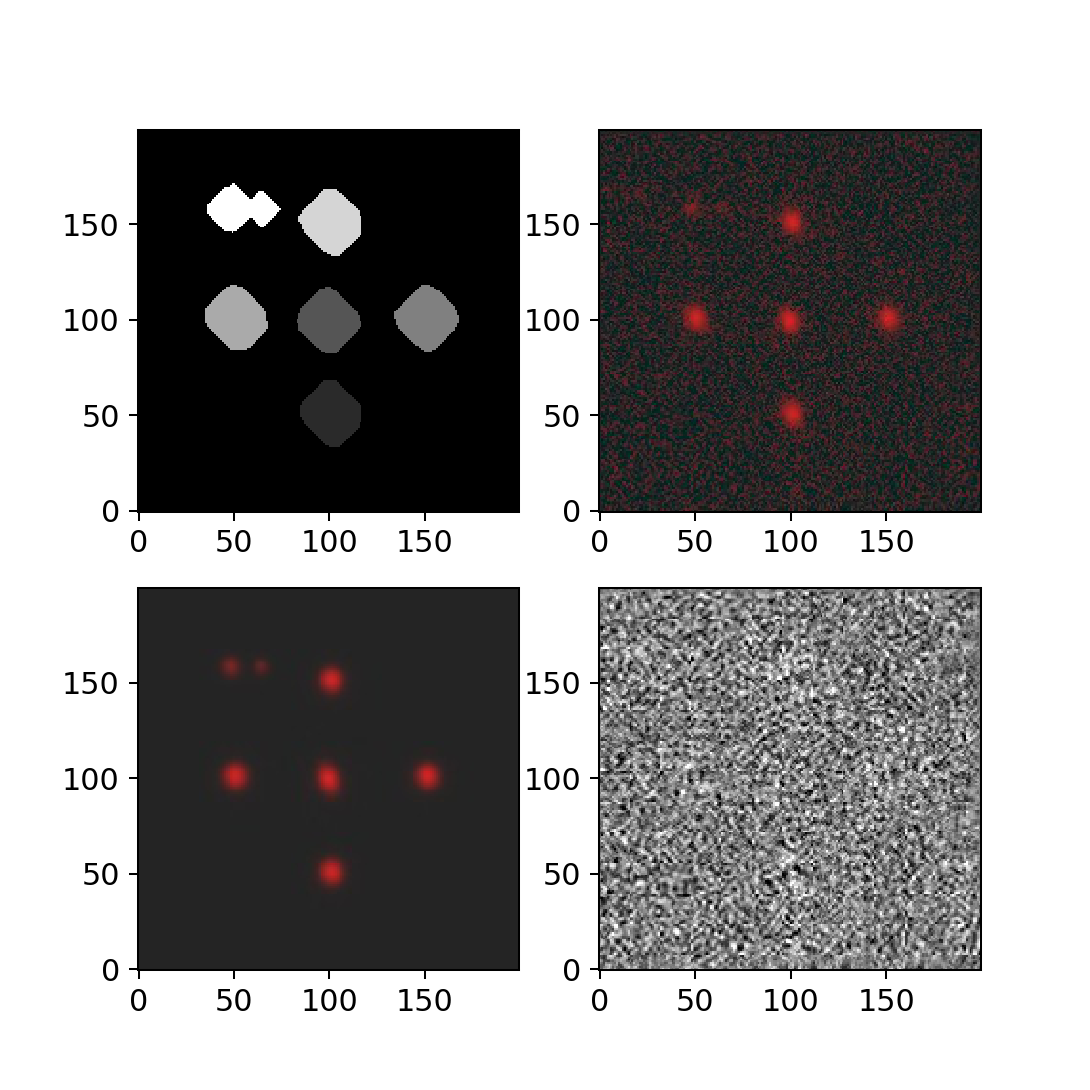

In [40]:
fig,ax=plt.subplots(2,2,figsize=(6,6))
plotImage().imshow(blobs,ax[0,0],qs=None)
plotImage().imshow(img_jpg,ax[0,1],qs=None)
plotImage().imshow(model_jpg,ax[1,0],qs=None)
plotImage().imshow(resid_jpg[:,:,0],ax[1,1])

In [ ]:
assert(len(obitractor) == 7)

In [28]:
# Split into recovered and missed and real
from astrometry.libkd.spherematch import match_radec
px_scale=0.25
rad= 10. * px_scale / 3600 #deg
isim,itrac,d= match_radec(simcat.ra, simcat.dec, obitractor.ra, obitractor.dec,          
                          rad,nearest=True)
len(itrac)

4

In [43]:
# real source at center
x_real,y_real= 100.,100.
dpix= np.sqrt((obitractor.bx - x_real)**2 + (obitractor.by - y_real)**2)       
ireal= [np.argmin(dpix)]


In [29]:
simcat.get_columns()

['id',
 'seed',
 'ra',
 'dec',
 'x',
 'y',
 'gflux',
 'rflux',
 'zflux',
 'sersicn',
 'rhalf',
 'ba',
 'phi']

<IPython.core.display.Javascript object>


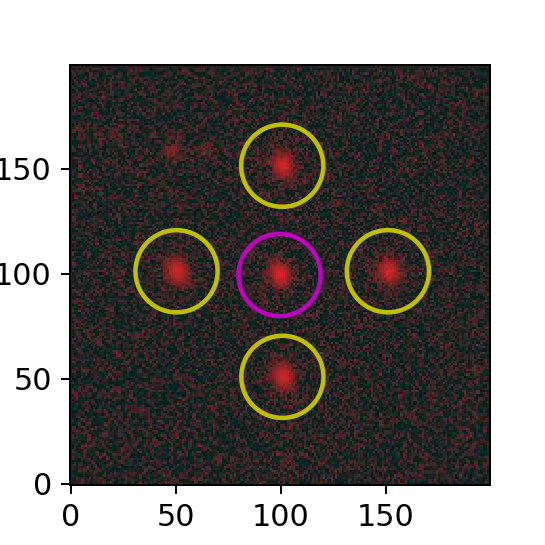

In [44]:
fig,ax=plt.subplots(figsize=(3,3))
plotImage().imshow(img_jpg,ax,qs=None)
plotImage().circles(obitractor[itrac].bx,obitractor[itrac].by,ax,
                    img_shape=img_jpg.shape,
                    r_pixels=5./0.262,color='y')
plotImage().circles(obitractor[ireal].bx,obitractor[ireal].by,ax,
                    img_shape=img_jpg.shape,
                    r_pixels=5./0.262,color='m')

### Measured mags are systematcially 0.1-0.2 mags brighter than truth mags. 

### Why? Is it due to add_flux being systematically larger than requested flux? something else?

In [56]:
assert(len(itrac) == 4)
print(simcat[isim].zflux-obitractor[itrac].flux_z)
print(np.sqrt(1/obitractor[itrac].flux_ivar_z))
print(flux2mag(simcat[isim].zflux)-flux2mag(obitractor[itrac].flux_z))


[ 5.21122546  6.07252688  3.67130084  5.38300128]
[ 0.35947144  0.34628338  0.36264539  0.35246661]
[-0.15895198 -0.18761943 -0.1095116  -0.16460918]


In [53]:
# sizes?
print(simcat[isim].rhalf-obitractor[itrac].shapeexp_r)

[-0.05292929  0.00552171 -0.0617463  -0.02213082]


In [62]:
# Does extinction vary by this much? I doubt it...
mags= flux2mag(obitractor[itrac].flux_z)
print('measured mag variation=',mags - np.median(mags))
mags= flux2mag(obitractor[itrac].flux_z/obitractor[itrac].mw_transmission_z)
print('extinction variation=',mags - np.median(mags))

('measured mag variation=', array([-0.0028286 ,  0.02583885, -0.05226898,  0.0028286 ], dtype=float32))
('extinction variation=', array([-0.00277519,  0.02588844, -0.05211258,  0.00277328], dtype=float32))


In [63]:
np.std(obitractor.mw_transmission_z)

6.3469575e-05

### sim sources should have similar flux to real galaxy at center

In [55]:
# Diff b/w fake truth and measure real galaxy identical
print(simcat[isim].zflux-obitractor[ireal].flux_z)
print(flux2mag(simcat[isim].zflux)-flux2mag(obitractor[ireal].flux_z))

[-0.0012341 -0.0012341 -0.0012341 -0.0012341]
0.353579661544
[  3.50162096e-05   3.50162096e-05   3.50162096e-05   3.50162096e-05]


In [48]:
# But diff b/w measure fake and measure real galaxy are large
print(obitractor[itrac].flux_z-obitractor[ireal].flux_z)
print(flux2mag(obitractor[itrac].flux_z)-flux2mag(obitractor[ireal].flux_z))

[-5.21245956 -6.07376099 -3.67253494 -5.38423538]
[ 0.15898705  0.1876545   0.10954666  0.16464424]


# testcase_DR_grz_200x200

In [10]:
brick='0285m165'
OUT_DIR= os.path.join(os.environ['HOME'],
                       'myrepo/obiwan/tests/end_to_end',
                       'out_testcase_DR5_grz_200x200/elg/%s/%s/rs0/' % \
                         (brick[:3],brick)
                     )
IN_DIR= os.path.join(os.environ['HOME'],
                       'myrepo/obiwan/tests/end_to_end',
                       'testcase_DR5_grz_200x200/')

simcat= fits_table(os.path.join(OUT_DIR,'obiwan/simcat-elg-%s.fits' % brick))
obitractor= fits_table(os.path.join(OUT_DIR,'tractor/tractor-%s.fits' % brick))

blobs= fitsio.FITS(os.path.join(OUT_DIR,'metrics/blobs-%s.fits.gz' % brick))[0].read()

img_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-%s-image.jpg' % brick),
                   jpeg=True)
model_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-%s-model.jpg' % brick),
                     jpeg=True)
resid_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-%s-resid.jpg' % brick),
                     jpeg=True)
                            

In [11]:
len(simcat),len(obitractor),blobs.shape

(4, 10, (200, 200))

<IPython.core.display.Javascript object>


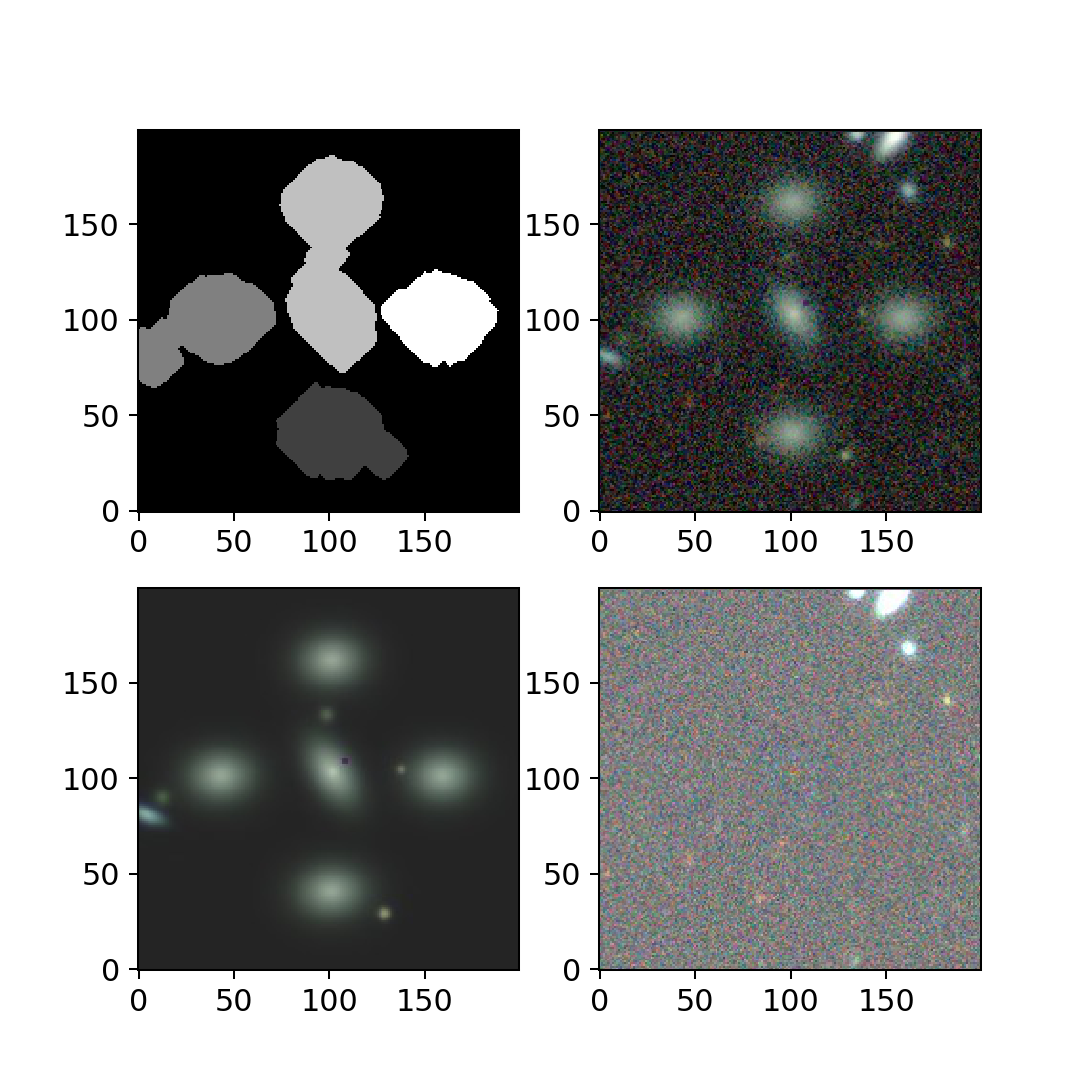

In [12]:
fig,ax=plt.subplots(2,2,figsize=(6,6))
plotImage().imshow(blobs,ax[0,0],qs=None)
plotImage().imshow(img_jpg,ax[0,1],qs=None)
plotImage().imshow(model_jpg,ax[1,0],qs=None)
plotImage().imshow(resid_jpg,ax[1,1],qs=None)

# testcase_DR_grz_200x200_allblobs

In [7]:
brick='0285m165'
OUT_DIR= os.path.join(os.environ['HOME'],
                       'myrepo/obiwan/tests/end_to_end',
                       'out_testcase_DR5_grz_200x200_allblobs/elg/%s/%s/rs0/' % \
                         (brick[:3],brick)
                     )
IN_DIR= os.path.join(os.environ['HOME'],
                       'myrepo/obiwan/tests/end_to_end',
                       'testcase_DR5_grz_200x200_allblobs/')

simcat= fits_table(os.path.join(OUT_DIR,'obiwan/simcat-elg-%s.fits' % brick))
obitractor= fits_table(os.path.join(OUT_DIR,'tractor/tractor-%s.fits' % brick))

blobs= fitsio.FITS(os.path.join(OUT_DIR,'metrics/blobs-%s.fits.gz' % brick))[0].read()

img_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-%s-image.jpg' % brick),
                   jpeg=True)
model_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-%s-model.jpg' % brick),
                     jpeg=True)
resid_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-%s-resid.jpg' % brick),
                     jpeg=True)
                            

In [8]:
len(simcat),len(obitractor),blobs.shape

(4, 20, (200, 200))

<IPython.core.display.Javascript object>


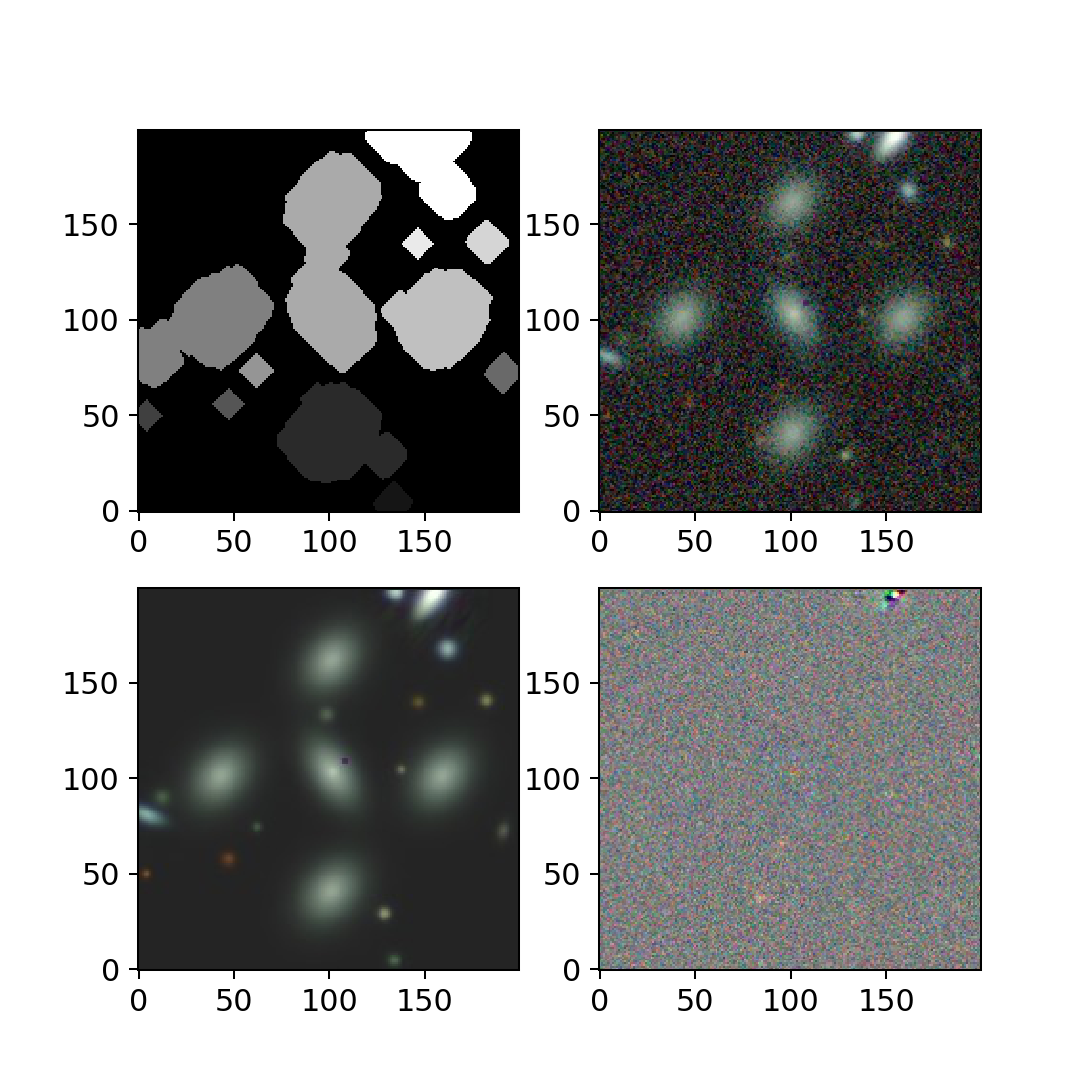

In [9]:
fig,ax=plt.subplots(2,2,figsize=(6,6))
plotImage().imshow(blobs,ax[0,0],qs=None)
plotImage().imshow(img_jpg,ax[0,1],qs=None)
plotImage().imshow(model_jpg,ax[1,0],qs=None)
plotImage().imshow(resid_jpg,ax[1,1],qs=None)

In [6]:
!ls $OUT_DIR/tractor/tractor-


brick-1741p242.sha256sum  tractor-1741p242.fits


# What "zoom" is needed for this testcase?

<IPython.core.display.Javascript object>


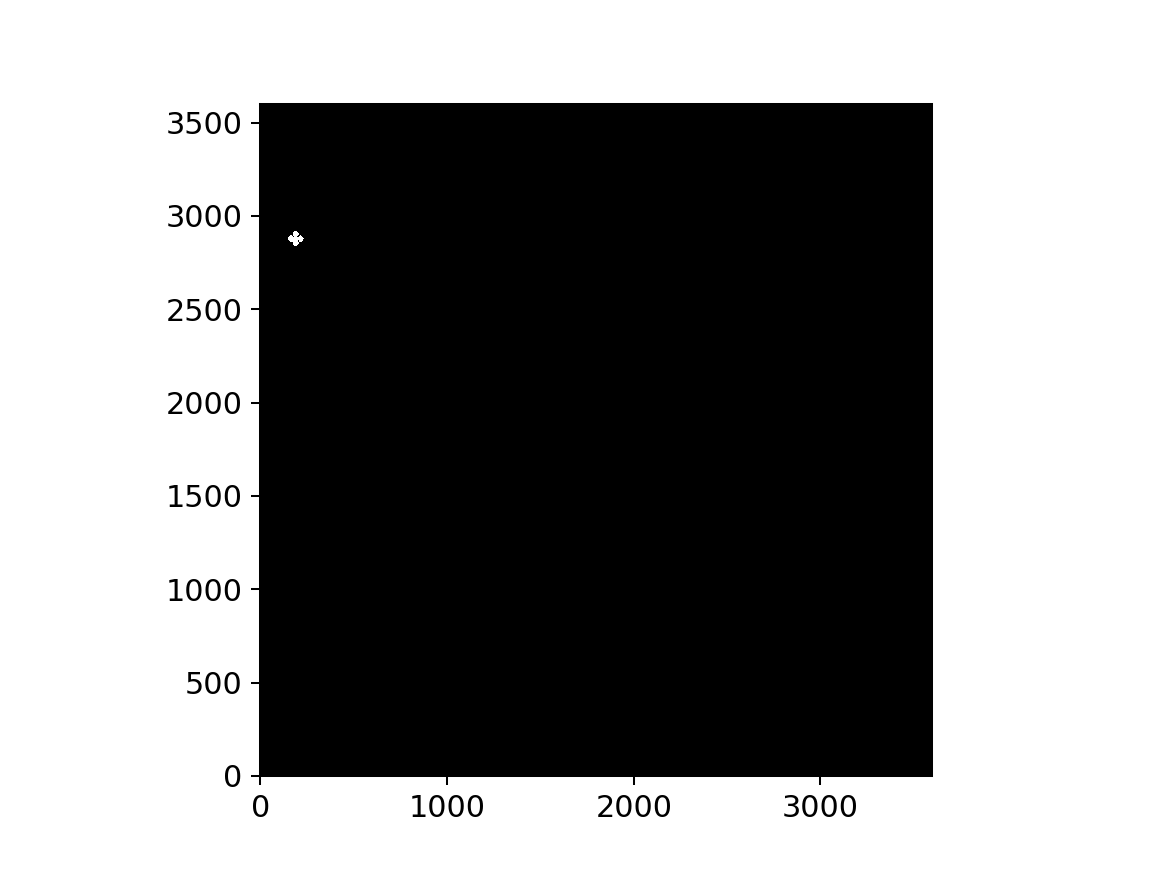

In [22]:
fig,ax=plt.subplots()
plotImage().imshow(blobs,ax,qs=None)

In [27]:
ra=[174.24714700910047, 174.24715333044438, 174.24915898792247, 174.2451413528916]
dec=[24.326224120319477, 24.32988191327332, 24.328050866811363, 24.32805515572893]
np.mean(ra),np.mean(dec)

(174.24715017008975, 24.328053014033273)

In [41]:
os.environ["LEGACY_SURVEY_DIR"]= IN_DIR

from legacypipe.survey import LegacySurveyData, wcs_for_brick
survey = LegacySurveyData()
brickinfo = survey.get_brick_by_name('1741p242')
brickwcs = wcs_for_brick(brickinfo)

AttributeError: 'NoneType' object has no attribute 'ra'

In [28]:
brickwcs.radec2pixelxy(174.24715,24.32805)

(True, 190.26994464884524, 2873.6879080454523)

<IPython.core.display.Javascript object>


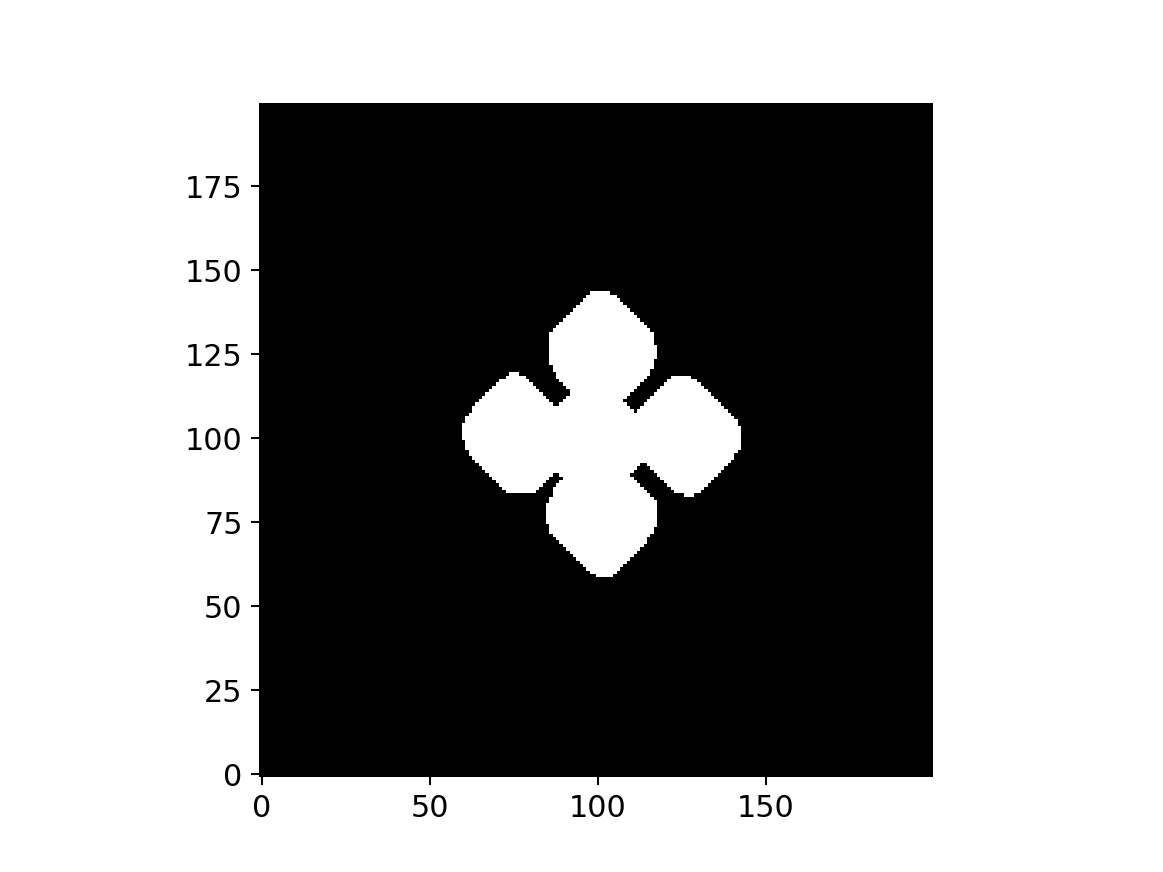

(slice(90, 290, None), slice(2773, 2973, None))


In [38]:
_,x,y= brickwcs.radec2pixelxy(174.2471,24.3262)
x,y= int(x),int(y)+25
hw=100

fig,ax=plt.subplots()
xslc=slice(x-hw,x+hw)
yslc=slice(y-hw,y+hw)
plotImage().imshow(sliceImage(blobs,xslice=xslc,yslice=yslc),
                   ax,qs=None)
print(xslc,yslc)

# Find som isolated sources with 3 bands, make 4 testcases 1 per band and 1 all-band

 1) use viewer to find good source, write down brickname, ra,dec of source and 3 good ccds touching that ra,dec by clicking on the source in the viewer
 
 2) grab the coadd/ccds file for that brick and cut to just those three ccds
 
 3) run create_testcase uses the 3-ccd ccd file
 
 4) put resulting legacysurvydir, tractor catalogue, img jpg, and 3 ccd coadd ccds file on labptop
 
 5) run the cells below 
 
 6) In the end you'll run **create_testcase**. This func needs a ccds file which is the coadd/ccds file with ccd_x0,...,ccd_y1 modified to be the pixel range for each ccd that touches the desired source
 
 7) to get ccd_x0, y1 values use the coadd/ccd table to make a tim objec for each ccd, print out the x,y for the ra,dec of the source using the tim.wcs.wcs.radec2xypixel func
 
 8) modify the ccd_x0,y1 values to be +- 100 pixels of each set of center x,y pixel values

In [43]:
# brick 0285m165, RA,Dec = (28.4194, -16.4362) in viewer looks like good 3 colors source
IN_DIR= os.path.join(os.environ['HOME'],
                     'myrepo/obiwan/tests/end_to_end',
                     'testcase_DR5_grz/')
os.environ["LEGACY_SURVEY_DIR"]= IN_DIR

survey = LegacySurveyData()
brickinfo = survey.get_brick_by_name('0285m165')
brickwcs = wcs_for_brick(brickinfo)

ra,dec= 28.4194, -16.4362
brickwcs.radec2pixelxy(ra,dec)

(True, 3177.4193025452664, 2676.786370753425)

In [67]:
brick='0285m165'
DATA_DIR= os.path.join(os.environ['HOME'],
                       'mydata',brick,'dr5')
dr5tractor= fits_table(os.path.join(DATA_DIR,
                      'tractor-%s.fits' % brick))
#ccds= fits_table(os.path.join(DATA_DIR,
#                 'dr5_3ccds.fits'))
#ccds= fits_table(os.path.join(DATA_DIR,
#                 'ccds_0285m165_dr5coadddir.fits'))
ccds= fits_table(os.path.join(IN_DIR,'survey-ccds-1.fits.gz'))

img_jpg= readImage(os.path.join(DATA_DIR,'legacysurvey-0285m165-image.jpg'),
                   jpeg=True)

<IPython.core.display.Javascript object>


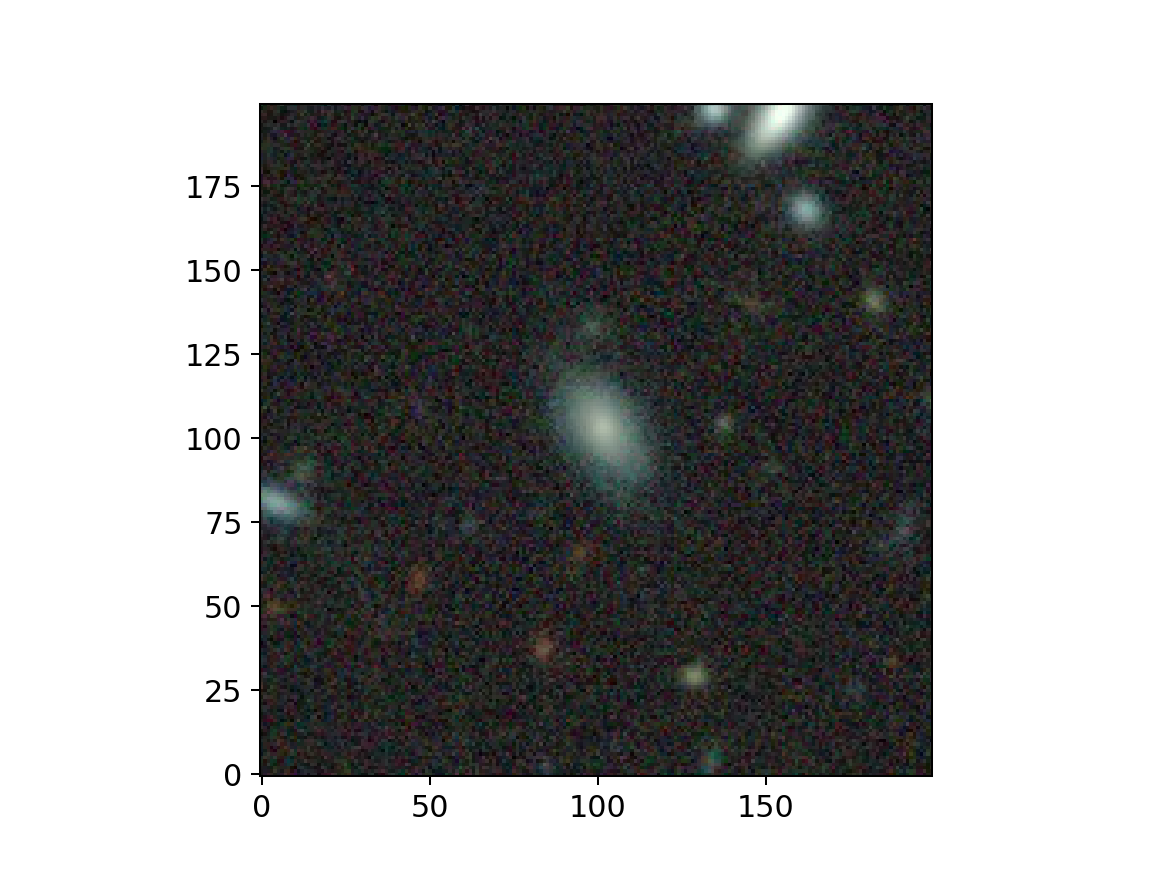

(slice(3077, 3277, None), slice(2576, 2776, None))


In [46]:
_,x,y= brickwcs.radec2pixelxy(ra,dec)
x,y= int(x),int(y)
hw=100

fig,ax=plt.subplots()
xslc=slice(x-hw,x+hw)
yslc=slice(y-hw,y+hw)
plotImage().imshow(sliceImage(img_jpg,xslice=xslc,yslice=yslc),
                   ax,qs=None)
print(xslc,yslc)

In [16]:
from legacypipe.decam import DecamImage
from legacypipe.survey import LegacySurveyData

In [80]:
kwargs = dict(pixPsf=True, splinesky=True, subsky=True, hybridPsf=True,
              pixels=True, dq=True, invvar=True)

survey = LegacySurveyData(ccds=ccds)
tims={}
#for col in ccds.get_columns():
#    if 'S' in str(ccds.get(col).dtype):
#        ccds.set(col,np.char.strip(ccds.get(col)))
for ccd in ccds:
    im = survey.get_image_object(ccd)
    tims[ccd.filter] = im.get_tractor_image(**kwargs)

Reading image slice: None
Reading image from /home/kaylan/myrepo/obiwan/tests/end_to_end/testcase_DR5_grz/images/decam/NonDECaLS/CP20141215/c4d_141206_043719_ooi_z_a1-S10.fits hdu 1
Reading inverse-variance from /home/kaylan/myrepo/obiwan/tests/end_to_end/testcase_DR5_grz/images/decam/NonDECaLS/CP20141215/c4d_141206_043719_oow_z_a1-S10.fits hdu 1
Reading data quality from /home/kaylan/myrepo/obiwan/tests/end_to_end/testcase_DR5_grz/images/decam/NonDECaLS/CP20141215/c4d_141206_043719_ood_z_a1-S10.fits hdu 1
Merged spline sky model does not exist: /home/kaylan/myrepo/obiwan/tests/end_to_end/testcase_DR5_grz/calib/decam/splinesky-merged/00384/decam-00384128.fits
Reading sky model from /home/kaylan/myrepo/obiwan/tests/end_to_end/testcase_DR5_grz/calib/decam/splinesky/00384/00384128/decam-00384128-S10.fits
Instantiating and subtracting sky model
Merged PsfEx model does not exist: /home/kaylan/myrepo/obiwan/tests/end_to_end/testcase_DR5_grz/calib/decam/psfex-merged/00384/decam-00384128.fits


In [81]:
tim=tims['g']
tim.wcs.wcs.radec2pixelxy(ra,dec)

(True, 918.0465384893796, 420.42404627704695)

<IPython.core.display.Javascript object>


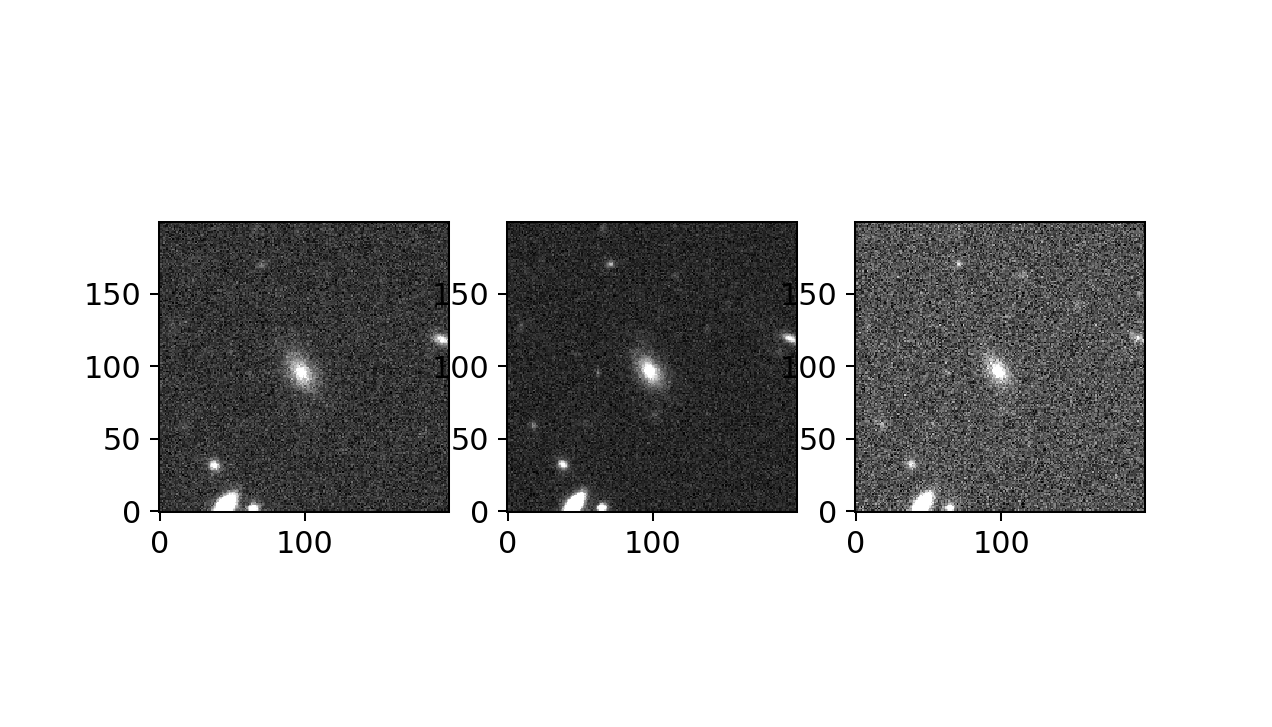

In [82]:
_,x,y= tim.wcs.wcs.radec2pixelxy(ra,dec)
x,y= int(x),int(y)
hw=100
xslc,yslc= slice(x-hw,x+hw),slice(y-hw,y+hw)

fig,ax=plt.subplots(1,3,figsize=(7,4))
for i,band in enumerate(['g','r','z']):
    plotImage().imshow(sliceImage(tims[band].getImage(),xslice=xslc,yslice=yslc).T,
                       ax[i])

<IPython.core.display.Javascript object>


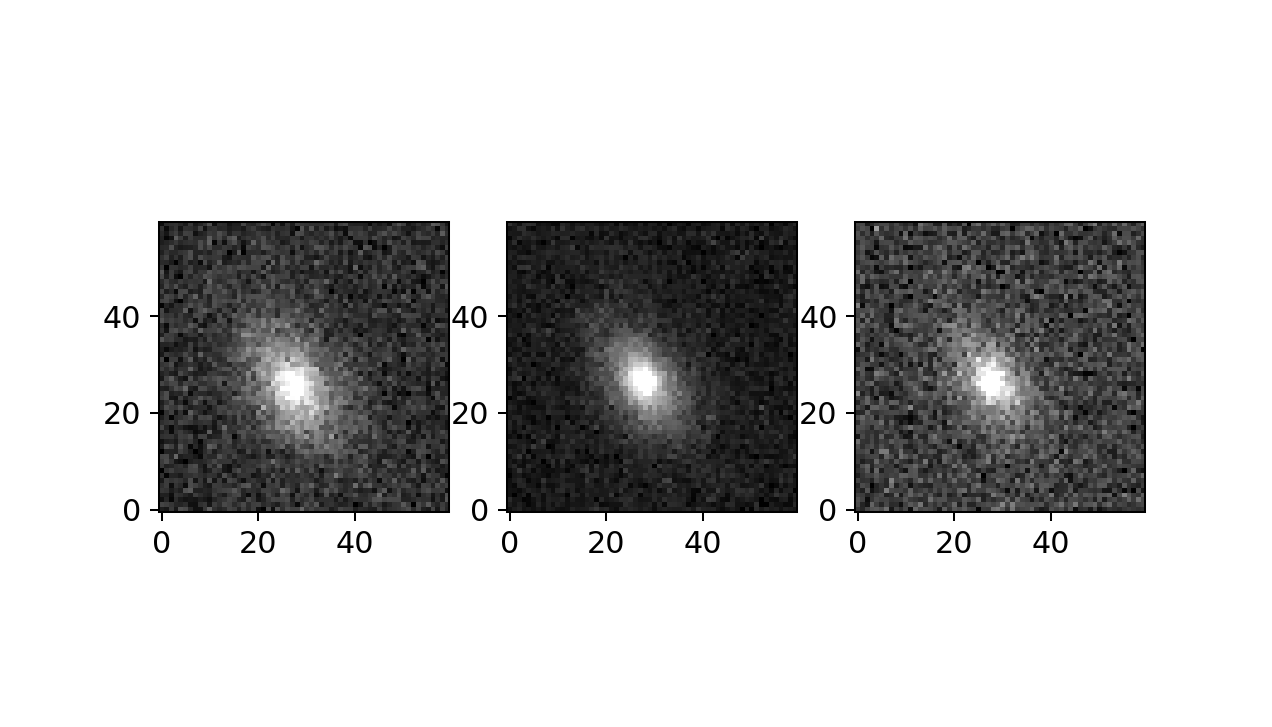

('g', 'nanomags=', 17.956371, 'mags=', 19.364453556756388)
('r', 'nanomags=', 32.756645, 'mags=', 18.711751458105404)
('z', 'nanomags=', 46.451378, 'mags=', 18.332503497939175)


In [87]:
def flux2mag(flux):
    return -2.5*np.log10(1e-9 * flux)

hw=30
xslc,yslc= slice(x-hw,x+hw),slice(y-hw,y+hw)

fig,ax=plt.subplots(1,3,figsize=(7,4))
for i,band in enumerate(['g','r','z']):
    img= sliceImage(tims[band].getImage(),xslice=xslc,yslice=yslc).T
    plotImage().imshow(img,ax[i])
    # Extract the nanomaggie flux for each band that we will add to the images
    print(band,'nanomags=',img.sum(),'mags=',flux2mag(img.sum()))

In [72]:
# flux of this galaxy
from astrometry.libkd.spherematch import match_radec
_,itrac,d= match_radec(np.array([ra]), np.array([dec]), dr5tractor.ra, dr5tractor.dec,          
                        5./3600.0,nearest=True)
itrac

array([4962], dtype=int32)

In [74]:
trac=dr5tractor.copy()
trac.cut(itrac)
len(trac)

1

In [76]:
trac.ra,trac.dec, ra,dec

(array([ 28.4192355]), array([-16.43595489]), 28.4194, -16.4362)

In [88]:
# Tractor measurements on many imags should be close to above values for the three images
for band in ['g','r','z']:
    flux=trac.get('flux_'+band)
    print(band,'nanomags=',flux,'mags=',flux2mag(flux))

('g', 'nanomags=', array([ 16.06177902], dtype=float32), 'mags=', array([ 19.48551559], dtype=float32))
('r', 'nanomags=', array([ 31.8071003], dtype=float32), 'mags=', array([ 18.74369049], dtype=float32))
('z', 'nanomags=', array([ 52.83349609], dtype=float32), 'mags=', array([ 18.19272614], dtype=float32))


In [89]:
trac.ra,trac.dec,trac.type,flux2mag(trac.flux_g),flux2mag(trac.flux_r),flux2mag(trac.flux_z)

(array([ 28.4192355]), array([-16.43595489]), array(['EXP '],
       dtype='|S4'), array([ 19.48551559], dtype=float32), array([ 18.74369049], dtype=float32), array([ 18.19272614], dtype=float32))

In [90]:
trac.shapeexp_r,trac.shapeexp_e1,trac.shapeexp_e2

(array([ 2.4597683], dtype=float32),
 array([ 0.12245165], dtype=float32),
 array([ 0.23880503], dtype=float32))

(28.4194, -16.4362)
[28.423766666666666, 28.415033333333334, 28.4194, 28.4194]
[-16.4362, -16.4362, -16.431833333333334, -16.440566666666665]
[ 918.6980714   918.75985247  859.09916007  978.3570594 ]
[ 477.86830435  363.5315702   420.66734678  420.73262761]


<IPython.core.display.Javascript object>


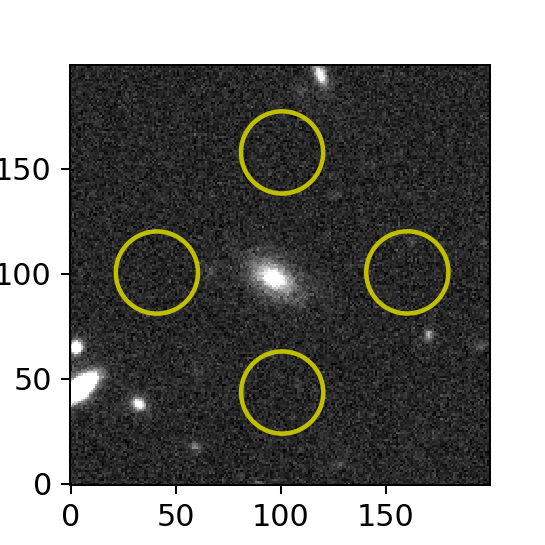

('IMAGE SLICE:', slice(818, 1018, None), slice(320, 520, None))


In [104]:
# Lets circle ra,dec where we'll add galaxies to the r-band image
print(ra,dec)
tim= tims['r']
dd= 60 * 0.262 /3600 # pix*as/pix converted to deg
newra,newdec=[],[]
for dx,dy in zip([dd,-dd,0,0],[0,0,dd,-dd]):
    #newx,newy=x+dx,y+dy
    #ra,dec= tim.wcs.wcs.pixelxy2radec(newx,newy)
    #print(newx,newy,ra,dec)
    newra.append(ra + dx)
    newdec.append(dec + dy)
print(newra)
print(newdec)
_,newx,newy= tim.wcs.wcs.radec2pixelxy(newra,newdec)
print(newx)
print(newy)

_,x,y= tim.wcs.wcs.radec2pixelxy(ra,dec)
x,y= int(x),int(y)
hw=100
xslc,yslc= slice(x-hw,x+hw),slice(y-hw,y+hw)

fig,ax=plt.subplots(figsize=(3,3))
plotImage().imshow(sliceImage(tims['r'].getImage(),xslice=xslc,yslice=yslc),
                   ax)
# cirlces
plotImage().circles(newx,newy,ax,
                    xslice=xslc,yslice=yslc,
                    r_pixels=5./0.262,color='y')
print('IMAGE SLICE:',xslc,yslc)

## Now find ccd_x0, ..., ccd_y1 for each ccd

In [125]:
# start with coadd/ccds
ccds= fits_table(os.path.join(DATA_DIR,
                 'ccds_0285m165_dr5coadddir.fits'))

In [111]:
kwargs = dict(pixPsf=True, splinesky=True, subsky=True, hybridPsf=True,
              pixels=True, dq=False, invvar=False)


survey = LegacySurveyData(ccds=ccds)
vals=[]
for band in ['g','r','z']:
    t= ccds[ccds.filter == band]
    for ccd in t:
        im = survey.get_image_object(ccd)
        tim = im.get_tractor_image(**kwargs)
        _,x,y= tim.wcs.wcs.radec2pixelxy(ra,dec)
        print(band,int(x),int(y))
        vals.append( (band,int(x),int(y)) )

Reading image slice: None
Reading image from /home/kaylan/myrepo/obiwan/tests/end_to_end/testcase_DR5_grz/images/decam/NonDECaLS/CP20141215/c4d_141223_020302_ooi_g_a1.fits.fz hdu 20
Merged spline sky model does not exist: /home/kaylan/myrepo/obiwan/tests/end_to_end/testcase_DR5_grz/calib/decam/splinesky-merged/00390/decam-00390498.fits
Reading sky model from /home/kaylan/myrepo/obiwan/tests/end_to_end/testcase_DR5_grz/calib/decam/splinesky/00390/00390498/decam-00390498-S10.fits
Instantiating and subtracting sky model
sig1 estimate: 0.00575166300675
Merged PsfEx model does not exist: /home/kaylan/myrepo/obiwan/tests/end_to_end/testcase_DR5_grz/calib/decam/psfex-merged/00390/decam-00390498.fits
Reading PsfEx model from /home/kaylan/myrepo/obiwan/tests/end_to_end/testcase_DR5_grz/calib/decam/psfex/00390/00390498/decam-00390498-S10.fits
Using PSF model HybridPixelizedPSF: Gaussian sigma 2.10, Pix PixelizedPsfEx
-- creating constant PSF model for norms...
PSF norm: 0.123362
Galaxy norm 0.09

In [114]:
print(vals)
dx=100
from collections import defaultdict
x0,x1,y0,y1= defaultdict(list),defaultdict(list),defaultdict(list),defaultdict(list)
for b,xc,yc in vals:
    x0[b] += [=xc-100,xc+100,yc-100,yc+100)

[('g', 1814, 3205), ('r', 1783, 3215), ('z', 1782, 3263)]
('g', 1714, 1914, 3105, 3305)
('r', 1683, 1883, 3115, 3315)
('z', 1682, 1882, 3163, 3363)


In [122]:
IN_DIR= os.path.join(os.environ['HOME'],
                     'myrepo/obiwan/tests/end_to_end',
                     'testcase_DR5_grz_200x200/')
g=fitsio.FITS(os.path.join(IN_DIR,'images/decam/NonDECaLS/CP20141215/',
                             'c4d_141223_020302_ooi_g_a1-S10.fits'))[1].read()
r=fitsio.FITS(os.path.join(IN_DIR,'images/decam/NonDECaLS/CP20141215/',
                             'c4d_141224_033245_ooi_r_a1-S10.fits'))[1].read()
z=fitsio.FITS(os.path.join(IN_DIR,'images/decam/NonDECaLS/CP20141215/',
                             'c4d_141206_043719_ooi_z_a1-S10.fits'))[1].read()
g.shape

(200, 200)

<IPython.core.display.Javascript object>


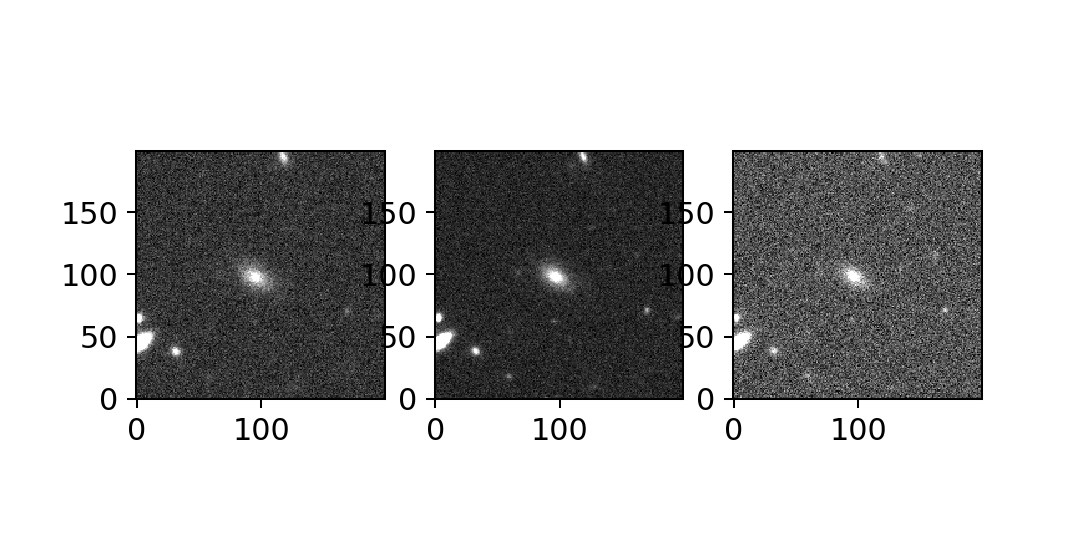

In [123]:
fig,ax=plt.subplots(1,3,figsize=(6,3))
plotImage().imshow(g,ax[0])
plotImage().imshow(r,ax[1])
plotImage().imshow(z,ax[2])

It worked!

# Extra Test Cases: no longer needed or equiv. to those in the code

## testcase_DR_z with 6'' separation

In [5]:
OUT_DIR= os.path.join(os.environ['HOME'],
                       'myrepo/obiwan/tests/end_to_end',
                       'out_testcase_DR5_z/elg/174/1741p242/rs0/')
IN_DIR= os.path.join(os.environ['HOME'],
                       'myrepo/obiwan/tests/end_to_end',
                       'testcase_DR5_z/')

simcat= fits_table(os.path.join(OUT_DIR,'obiwan/simcat-elg-1741p242.fits'))
obitractor= fits_table(os.path.join(OUT_DIR,'tractor/tractor-1741p242.fits'))

blobs= fitsio.FITS(os.path.join(OUT_DIR,'metrics/blobs-1741p242.fits.gz'))[0].read()

img_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-1741p242-image.jpg'),
                   jpeg=True)
model_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-1741p242-model.jpg'),
                     jpeg=True)
resid_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-1741p242-resid.jpg'),
                     jpeg=True)
                            

In [6]:
len(simcat),len(obitractor),blobs.shape

(4, 3, (200, 200))

<IPython.core.display.Javascript object>


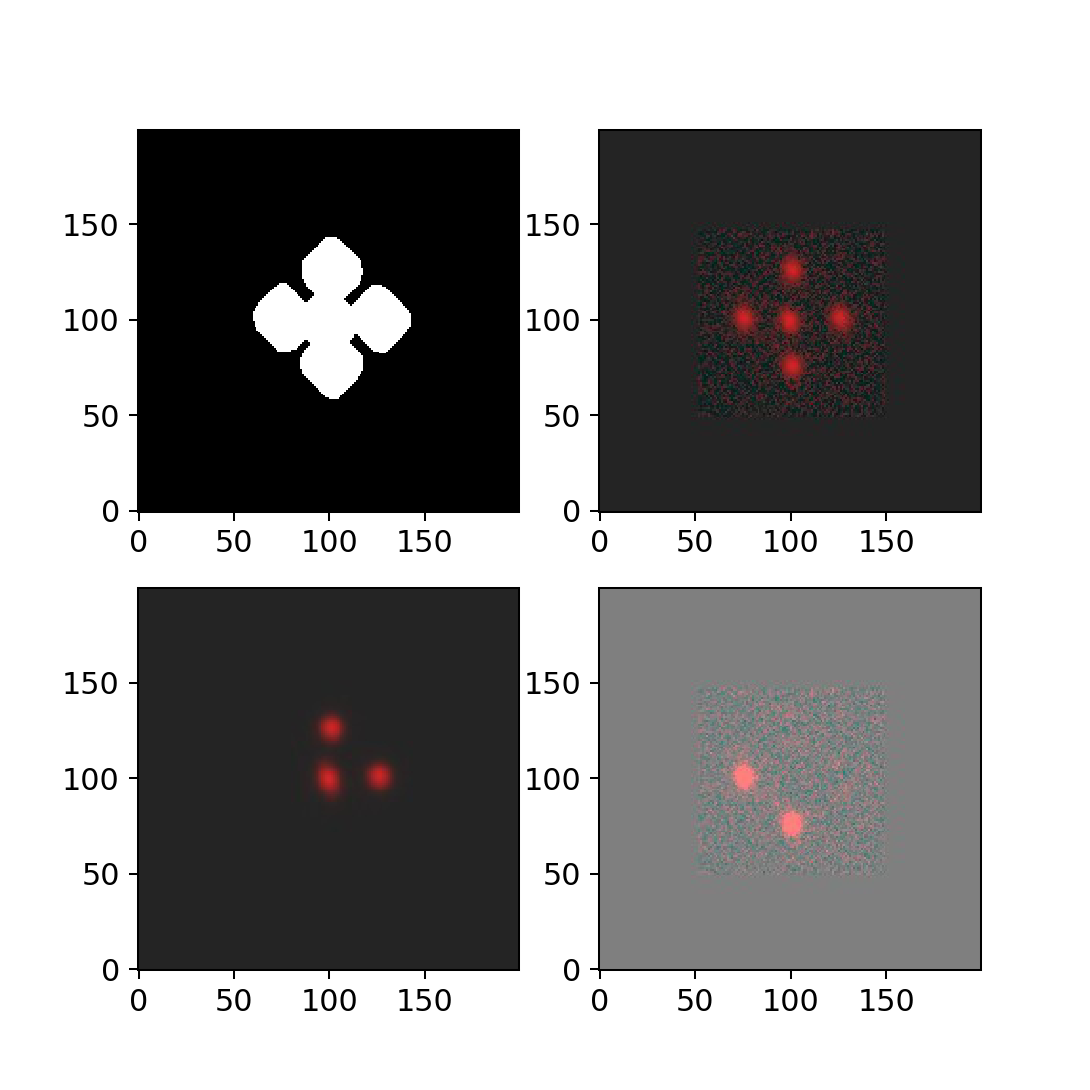

In [7]:
fig,ax=plt.subplots(2,2,figsize=(6,6))
plotImage().imshow(blobs,ax[0,0],qs=None)
plotImage().imshow(img_jpg,ax[0,1],qs=None)
plotImage().imshow(model_jpg,ax[1,0],qs=None)
plotImage().imshow(resid_jpg,ax[1,1],qs=None)

## testcase_DR_z_allblobs with 6'' separation

In [8]:
OUT_DIR= os.path.join(os.environ['HOME'],
                       'myrepo/obiwan/tests/end_to_end',
                       'out_testcase_DR5_z_allblobs/elg/174/1741p242/rs0/')
IN_DIR= os.path.join(os.environ['HOME'],
                       'myrepo/obiwan/tests/end_to_end',
                       'testcase_DR5_z_allblobs/')

simcat= fits_table(os.path.join(OUT_DIR,'obiwan/simcat-elg-1741p242.fits'))
obitractor= fits_table(os.path.join(OUT_DIR,'tractor/tractor-1741p242.fits'))

blobs= fitsio.FITS(os.path.join(OUT_DIR,'metrics/blobs-1741p242.fits.gz'))[0].read()

img_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-1741p242-image.jpg'),
                   jpeg=True)
model_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-1741p242-model.jpg'),
                     jpeg=True)
resid_jpg= readImage(os.path.join(OUT_DIR,'coadd/legacysurvey-1741p242-resid.jpg'),
                     jpeg=True)
                            

In [9]:
len(simcat),len(obitractor),blobs.shape

(4, 3, (200, 200))

<IPython.core.display.Javascript object>


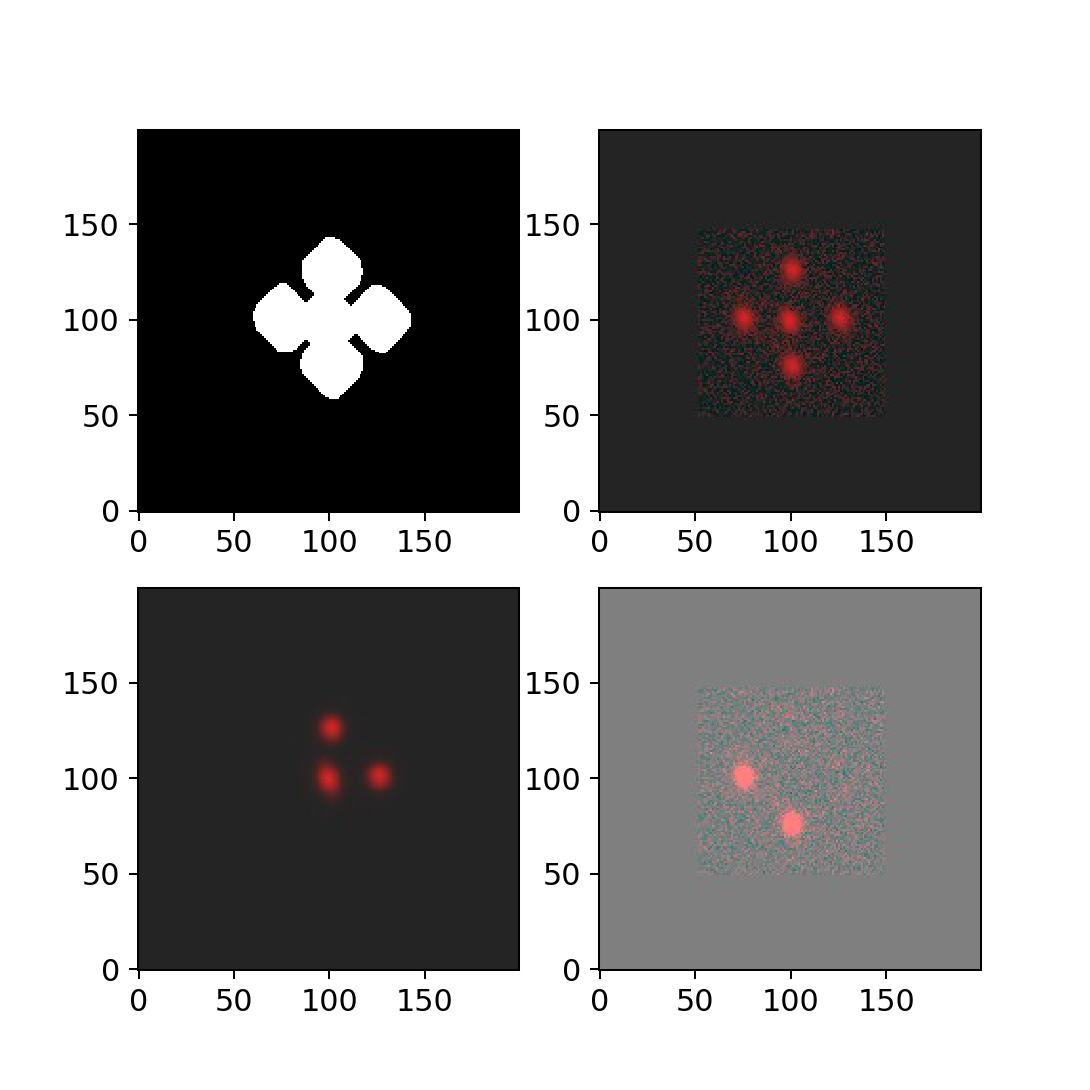

In [10]:
fig,ax=plt.subplots(2,2,figsize=(6,6))
plotImage().imshow(blobs,ax[0,0],qs=None)
plotImage().imshow(img_jpg,ax[0,1],qs=None)
plotImage().imshow(model_jpg,ax[1,0],qs=None)
plotImage().imshow(resid_jpg,ax[1,1],qs=None)